In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

so now we are loading dataset into tf dataset as i have learned in tf pipeline to fit datasets into tfpipeline for ease

In [39]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'datasets', #datasets
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),#(256, 256)
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_name = dataset.class_names
class_name


['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset) #batch of 32 images so into 3

68

batch, size, size, rgb channel /n
class no.s and because its in to tf dataset so everything is tensor to convert it we use numpy and which comes into tensorflow (justfor knowledge)

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 0 0 0 0 1 1 1 0 2 1 1 0 0 0 1 1 1 0 1 1 0 0 1 0 0 1 0 1 1 1]


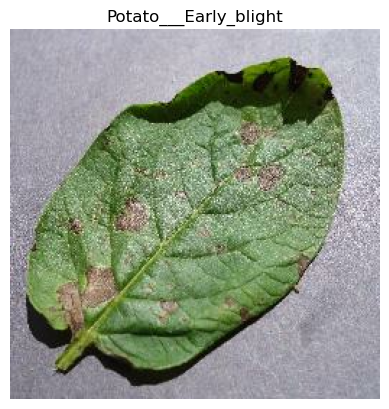

In [7]:
#lets vivuslaize
#eveytime its suffling
for image_batch, label_batch in dataset.take(1):
    # plt.imshow(image_batch[0].numpy()) this is float so
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    #i dont want numbers so 
    plt.axis('off')
    #but i want label
    plt.title(class_name[label_batch[0]]) #i provided label batch as index
    

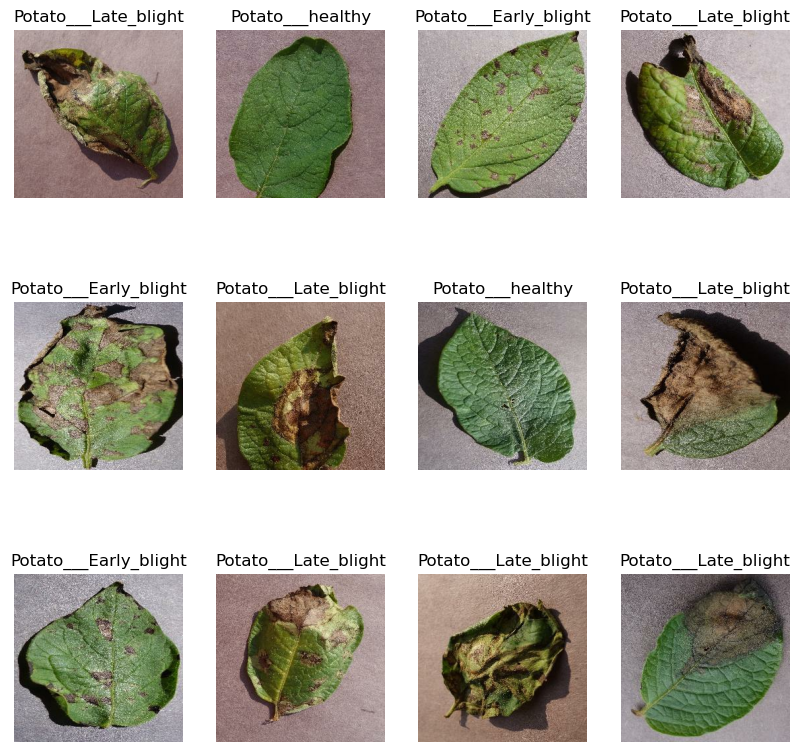

In [8]:
#lets vivuslaize 12 images
#eveytime its suffling
#just setting areas for clear vision
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1) #this will give a plan to show all others
        # plt.imshow(image_batch[0].numpy()) this is float so
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        #i dont want numbers so 
        plt.axis('off')
        #but i want label
        plt.title(class_name[label_batch[i]]) #i provided label batch as index
    

80% ==> TRAINING
20% ==> 10% Validation, 10% test

In [9]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [10]:
train_ds = dataset.take(54)
len(train_ds)

54

In [11]:
test_ds = dataset.skip(54) #skip first 54 and keep rest
len(test_ds)

14

In [12]:
val_size = 0.1
len(dataset)*val_size #validation set

6.800000000000001

In [13]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [14]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [15]:
#lets craete a function for all these
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

54

In [18]:
len(val_ds)


6

In [19]:
len(test_ds)


8

**Cache, Shuffle, and Prefetch the Dataset**


now will do cache() its used for skipping the again and again loading part and focuses on direct training by keeping those loaded batch into cache memory

prefetch it puts gpu on training when cpu is loading data

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [22]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [23]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

by trial and error we put this cnn errors 

In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [29]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
54/54 [==============================] - 93s 2s/step - loss: 0.3218 - accuracy: 0.8704 - val_loss: 0.2547 - val_accuracy: 0.9010
Epoch 2/10
54/54 [==============================] - 115s 2s/step - loss: 0.2704 - accuracy: 0.8877 - val_loss: 0.2244 - val_accuracy: 0.9115
Epoch 3/10
54/54 [==============================] - 117s 2s/step - loss: 0.1816 - accuracy: 0.9317 - val_loss: 0.4938 - val_accuracy: 0.8229
Epoch 4/10
54/54 [==============================] - 108s 2s/step - loss: 0.1925 - accuracy: 0.9225 - val_loss: 0.2749 - val_accuracy: 0.8750
Epoch 5/10
54/54 [==============================] - 119s 2s/step - loss: 0.1912 - accuracy: 0.9219 - val_loss: 0.2925 - val_accuracy: 0.8646
Epoch 6/10
54/54 [==============================] - 122s 2s/step - loss: 0.1359 - accuracy: 0.9479 - val_loss: 0.3062 - val_accuracy: 0.8906
Epoch 7/10
54/54 [==============================] - 124s 2s/step - loss: 0.1647 - accuracy: 0.9398 - val_loss: 0.1373 - val_accuracy: 0.9375
Epoch 8/10
54/

In [30]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 4s 438ms/step - loss: 0.2401 - accuracy: 0.9180


In [31]:
scores

[0.24013639986515045, 0.91796875]

In [32]:
history

In [33]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [34]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [35]:
history.history['accuracy']

[0.8703703880310059,
 0.8877314925193787,
 0.9317129850387573,
 0.9224537014961243,
 0.921875,
 0.9479166865348816,
 0.9398148059844971,
 0.9594907164573669,
 0.9658564925193787,
 0.9537037014961243]

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

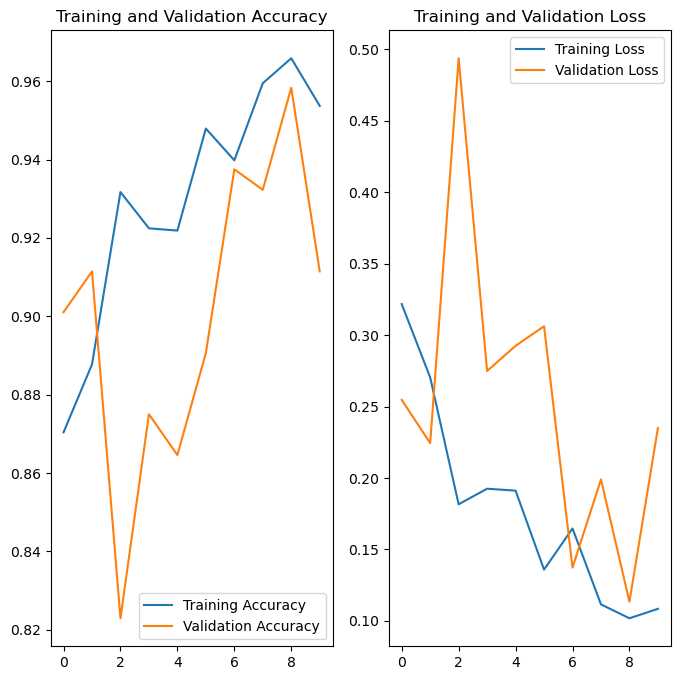

In [40]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 1s 624ms/step
predicted label: Potato___Early_blight


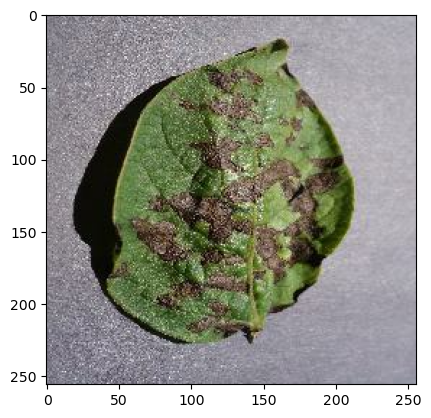

In [42]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_name[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_name[np.argmax(batch_prediction[0])])

Write a function for inference

In [43]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

Now run inference on few sample images

1/1 [==============================] - 0s 52ms/step


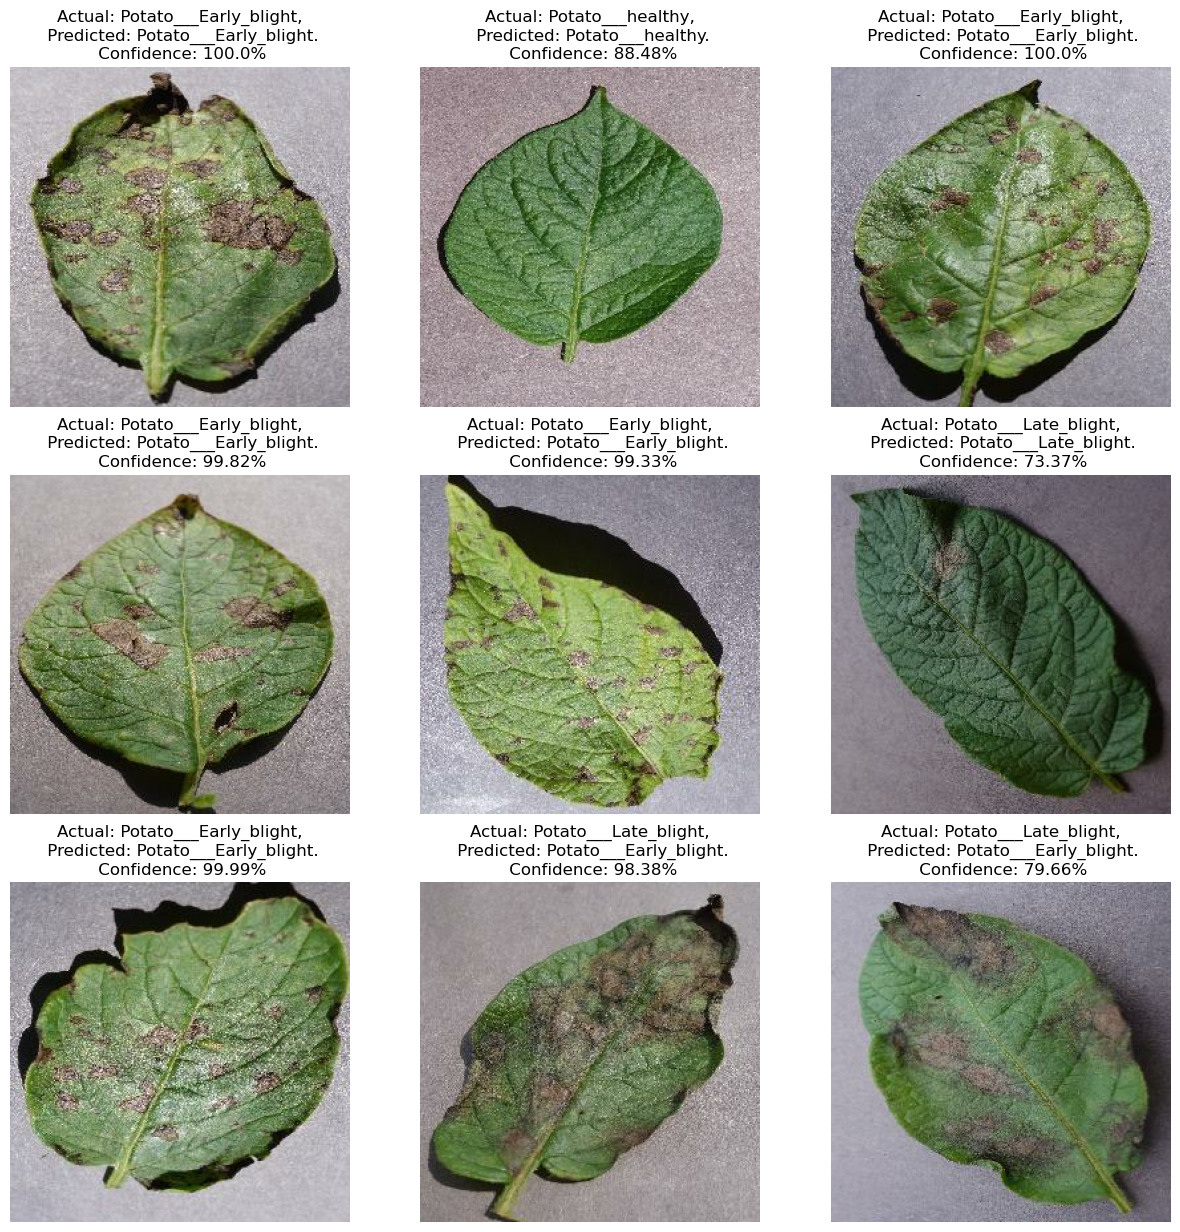

In [44]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [47]:
import os
model_version=max([int(i) for i in os.listdir("./models") + [0]])+1
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/1\assets


INFO:tensorflow:Assets written to: ./models/1\assets
